# Groen, groener, groenst
Voor iedere buurt in Breda surface temperature-data ophalen vanuit Earth Engine (blijkbaar iets heftiger dan NDVI), periode 2010 tot 2020, [MODIS](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1), 250x250 meter.

In [10]:
import ee
import datetime
import geopandas as gpd
import pandas as pd
import numpy as np

In [5]:
def get_stemp(start_date, end_date):
    '''to get surface temp data for breda, given start_date & end_date, returns image collection from start to end, filetered by aoi, only surface temp-band'''
    # init the ee object
    ee.Initialize()

    # define the area of interest
    breda = gpd.read_file('data/shape/breda.shp')
    breda = breda.to_crs(epsg=4326) # to lat-lon
    breda = breda.loc[0, 'geometry'].__geo_interface__
    AOI = ee.Geometry.Polygon(breda['coordinates'])

    # start - end date
    start_date = ee.Date(start_date)
    end_date = ee.Date(end_date)

    # return image collection
    return ee.ImageCollection('MODIS/006/MOD11A1').filterDate(start_date, end_date).filterBounds(AOI).select('LST_Day_1km')   

In [6]:
def to_dataframe(row):
    '''make dataframe containing mean surface temp for buurt, given row from geodataframe'''
    geometry = row['geometry'].__geo_interface__['coordinates'] # get coordinate list
    stempbuurt = stemp.getRegion(ee.Geometry.Polygon(geometry), 100).getInfo() # get points in geometry
    header = stempbuurt[0]
    data = np.array(stempbuurt[1:])

    time = [datetime.datetime.fromtimestamp(int(i)/1000) for i in data[0:,header.index('time')]] # convert timestamps
    values = data[0:,header.index('LST_Day_1km')] # evi-values
    return pd.DataFrame(values, index=time, columns=[row['BU_NAAM']]).astype(float).resample('d').mean()

In [11]:
# load breda buurten
buurten = gpd.read_file('data/shape/breda_buurten.shp')
buurten = buurten.to_crs(epsg=4326) # to lat-lon

# get average EVI for each buurt in one dataframe cols -> buurt
data = pd.DataFrame()
for year in range(2000,2020): # split up in one year at a time, to not overload api
    print('{}-{} => 2020'.format(year, year + 1))
    # get ndvi for given period
    stemp = get_stemp(start_date='{}-01-01'.format(year), end_date='{}-01-01'.format(year + 1))

    cols = pd.DataFrame()
    for i, row in buurten.iterrows():
        df = to_dataframe(row)
        cols = pd.concat([cols, df], axis=1)
        print('{}/{}'.format(i+1, len(buurten)), end='\r')
    data = pd.concat([data, cols], axis=0)
data = data * 0.02 - 273.15 # to celsius
data.to_csv('data/satdata/stemp.csv')

2000-2001 => 2020
2001-2002 => 2020
2002-2003 => 2020
2003-2004 => 2020
2004-2005 => 2020
2005-2006 => 2020
2006-2007 => 2020
2007-2008 => 2020
2008-2009 => 2020
2009-2010 => 2020
2010-2011 => 2020
2011-2012 => 2020
2012-2013 => 2020
2013-2014 => 2020
2014-2015 => 2020
2015-2016 => 2020
2016-2017 => 2020
2017-2018 => 2020
2018-2019 => 2020
2019-2020 => 2020


In [19]:
data.groupby(data.index.year).describe()

Valkenberg                                                         \
          count       mean        std        min        25%        50%   
2000       78.0  21.016230  10.223165  -2.406418  14.479254  20.844478   
2001       93.0  17.204901  12.294667  -6.750000   7.918060  17.150000   
2002      116.0  18.552997  10.473654  -2.127313  10.428060  18.168209   
2003      153.0  19.242864  11.690223 -17.510000   9.389701  19.279552   
2004      118.0  18.337277  10.465675 -22.544510   9.717164  20.026567   
2005      118.0  19.243854  11.245356  -4.248431   8.763426  21.460000   
2006      128.0  20.321416  12.404708  -0.691194   9.849776  20.179851   
2007      124.0  18.473306   9.544940  -2.290896  10.258333  19.155970   
2008      125.0  17.660497  10.496193  -1.204627   8.970000  17.578000   
2009      122.0  18.459105  11.469111 -13.750000  10.656493  21.607555   
2010      111.0  17.374628  14.337609 -18.610000   6.428507  20.864925   
2011      130.0  19.052210   9.920266   0.725224  10.039104  20.015522   
2012      120.0  17.922415  11.392607  -9.411791   9.355430  19.223134   
2013      106.0  18.972018  11.747016  -5.252985   8.871667  19.639403   
2014      125.0  19.470716   8.718696  -3.821642  13.315075  20.135672   
2015      126.0  18.661125  10.516420 -14.750000   9.233657  18.941472   
2016      123.0  19.075428  11.004002  -2.356667   8.359701  18.924925   
2017      111.0  19.336566  11.371745  -6.164627  10.475821  20.416567   
2018      145.0  22.149837  12.143306  -0.671791  12.091493  23.447015   
2019      134.0  19.906930  10.511005  -5.279851  10.512985  20.147761   

                           ChassÃ©             ... Vuchtpolder             \
            75%        max   count       mean  ...         75%        max   
2000  29.469776  40.424627    81.0  20.352600  ...   23.836345  35.032408   
2001  28.267313  39.054776    95.0  17.211141  ...   21.630338  34.259913   
2002  26.332313  39.000746   114.0  18.317524  ...   22.855233  32.392950   
2003  28.701343  39.921045   159.0  18.652955  ...   26.247370  34.224664   
2004  26.640896  35.434478   120.0  18.252447  ...   22.732923  31.406540   
2005  27.782985  41.715075   125.0  18.874194  ...   23.214705  36.785770   
2006  31.750373  44.727015   120.0  20.275037  ...   26.767176  38.741952   
2007  25.336592  37.132985   126.0  18.174906  ...   21.914776  33.765385   
2008  25.987910  38.096567   121.0  17.699842  ...   22.726098  31.970607   
2009  26.314478  36.399254   129.0  18.460393  ...   23.550746  31.558048   
2010  29.007015  41.064925   115.0  16.988380  ...   24.569414  37.678462   
2011  26.969254  37.405821   129.0  18.704280  ...   23.718841  33.572690   
2012  27.309403  37.577761   120.0  18.310263  ...   22.215521  32.137918   
2013  28.540075  42.240746   114.0  18.577876  ...   24.006550  36.575857   
2014  25.607612  36.699254   125.0  19.559775  ...   22.653764  30.970000   
2015  25.925821  40.734478   132.0  18.541611  ...   22.670968  35.962364   
2016  28.759385  39.325224   131.0  18.804469  ...   24.091193  33.332950   
2017  28.988507  40.093284   111.0  18.634555  ...   24.260214  35.006269   
2018  32.427910  43.971493   142.0  21.908560  ...   28.202067  40.298679   
2019  28.580000  40.228806   137.0  19.509272  ...   24.333439  35.867768   

     Buitengebied Teteringen                                              \
                       count       mean        std        min        25%   
2000                    95.0  17.093681   9.882180 -13.100244   9.990444   
2001                   111.0  14.439736  10.744667 -11.365472   5.541619   
2002                   129.0  16.537580   9.164934  -2.848538  10.028316   
2003                   156.0  17.082064  10.643917 -15.230000   8.993420   
2004                   125.0  16.064356   9.317003 -20.810000   8.503159   
2005                   122.0  17.391092   9.802299  -4.530000   9.860065   
2006                   132.0  17.921757  11.211949  -1.385666   8.820376 

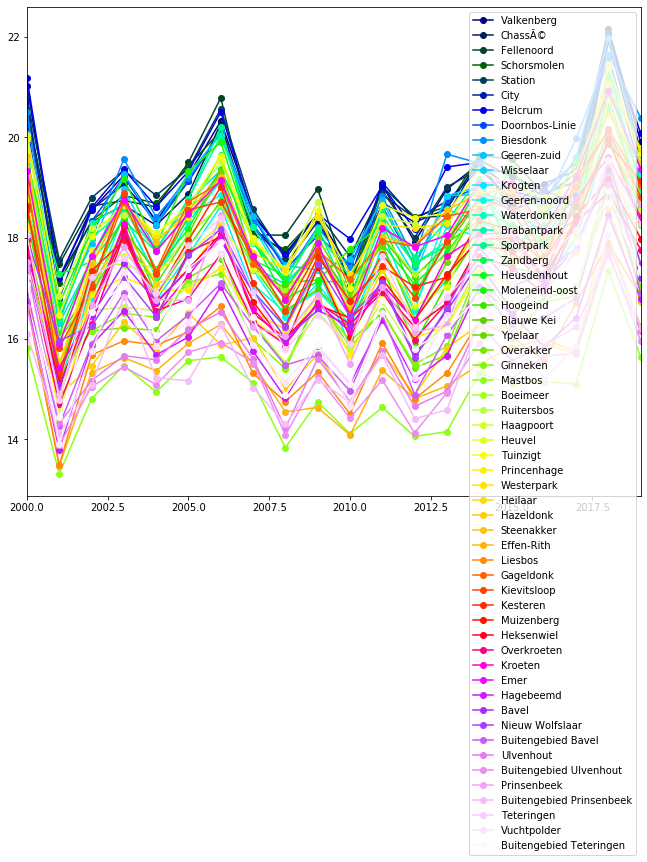

In [20]:
data.groupby(data.index.year).mean().plot(figsize=(11,9), style='-o', cmap='gist_ncar')

2000          AxesSubplot(0.1,0.77069;0.173913x0.12931)
2001     AxesSubplot(0.308696,0.77069;0.173913x0.12931)
2002     AxesSubplot(0.517391,0.77069;0.173913x0.12931)
2003     AxesSubplot(0.726087,0.77069;0.173913x0.12931)
2004         AxesSubplot(0.1,0.615517;0.173913x0.12931)
2005    AxesSubplot(0.308696,0.615517;0.173913x0.12931)
2006    AxesSubplot(0.517391,0.615517;0.173913x0.12931)
2007    AxesSubplot(0.726087,0.615517;0.173913x0.12931)
2008         AxesSubplot(0.1,0.460345;0.173913x0.12931)
2009    AxesSubplot(0.308696,0.460345;0.173913x0.12931)
2010    AxesSubplot(0.517391,0.460345;0.173913x0.12931)
2011    AxesSubplot(0.726087,0.460345;0.173913x0.12931)
2012         AxesSubplot(0.1,0.305172;0.173913x0.12931)
2013    AxesSubplot(0.308696,0.305172;0.173913x0.12931)
2014    AxesSubplot(0.517391,0.305172;0.173913x0.12931)
2015    AxesSubplot(0.726087,0.305172;0.173913x0.12931)
2016             AxesSubplot(0.1,0.15;0.173913x0.12931)
2017        AxesSubplot(0.308696,0.15;0.173913x0

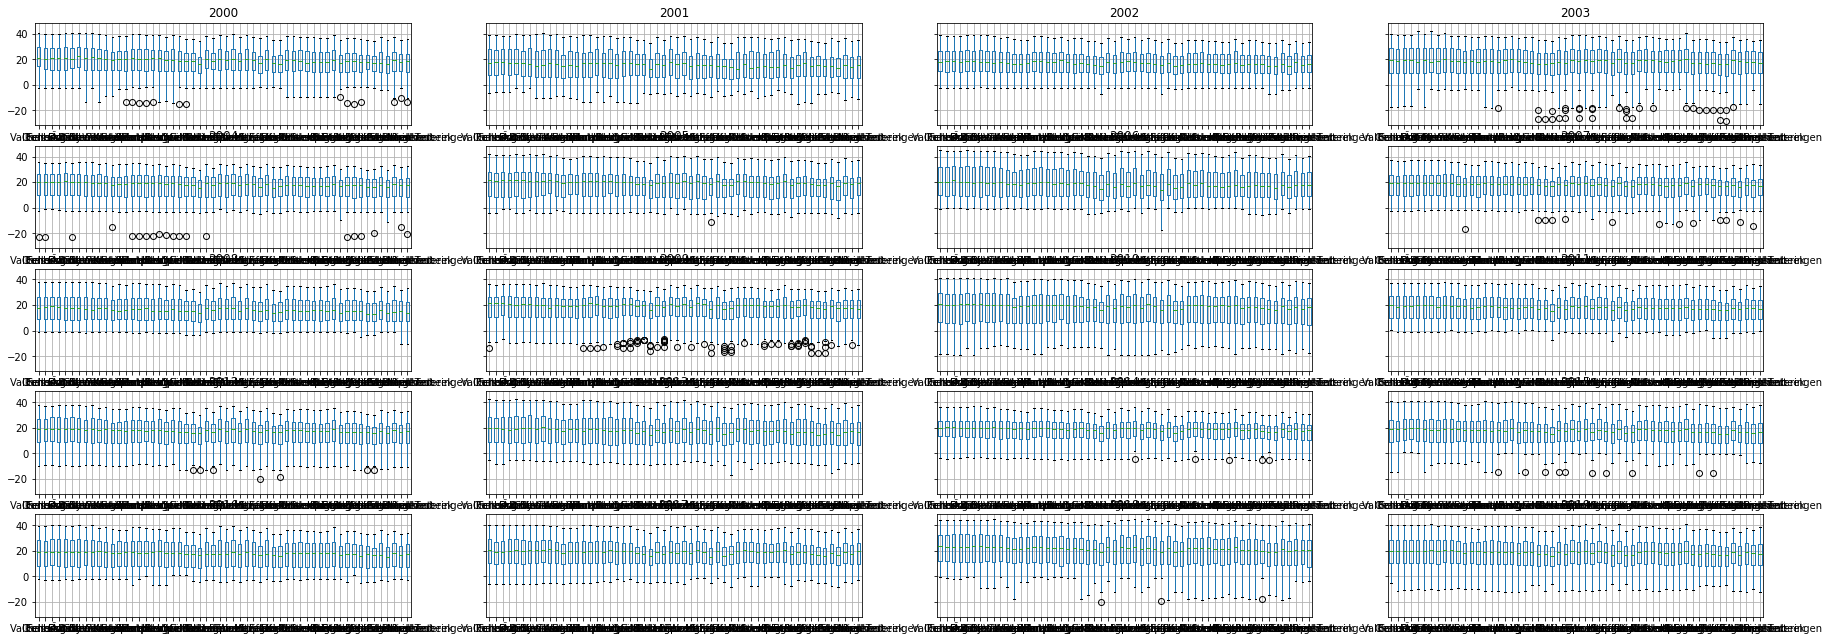

In [21]:
data.groupby(data.index.year).boxplot(figsize=(30,11))

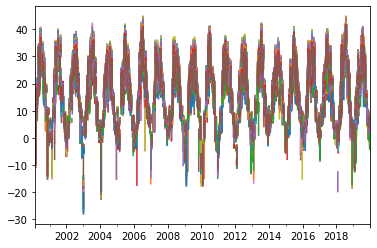

In [22]:
data.plot(legend=False)